#House Prices - Advanced Regression Techniques

## 1. Import Data & Libs

In [482]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random

In [483]:
train_data=pd.read_csv('/content/drive/MyDrive/House Prices - Advanced Regression Techniques/train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/House Prices - Advanced Regression Techniques/test.csv')


In [484]:
train_data.info()
test_data['Id']=test_data['Id'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Right off the bat, you can see that there are columns with a lot of missing values, like `PoolIQC` and `MiscFeature`.**

##2. Data preprocessing


###2.1 Drop columns with a high percentage of null values



In [485]:
train_data.isnull().mean().sort_values(ascending=False).head(9)

,0
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageCond,0.055479


I decided on a threshold of 17%. If a column has more null values than that, it will be dropped. I don't think it's worth it to invent data.

In [486]:
drop_cols=[]
for col in train_data.columns:
  if train_data[col].isnull().mean()>0.17:
    drop_cols.append(col)

train_data.drop(columns=drop_cols,inplace=True)
test_data.drop(columns=drop_cols,inplace=True)

###2.2 Categorical

In [509]:
weird_columns=[]
for col in train_data.columns:
  if np.dtype(train_data[col]) == object:
    weird_columns.append(col)

for i in weird_columns:
  print(i, train_data[i].unique())

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street ['Pave' 'Grvl']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkF

Now I’m analyzing the columns marked as objects to see if there’s any mix of letters and numbers or if they’re well-formatted.

In [488]:
def calculate_ratios(data, total_value):
    counts = np.array(data.value_counts().head(5))
    counts = counts[~np.isnan(counts)]
    k = total_value / np.sum(counts)
    scaled_values = k * counts
    rounded_values = np.round(scaled_values).astype(int)
    difference = total_value - np.sum(rounded_values)

    if difference != 0:
        adjustment_indices = np.argsort(scaled_values - rounded_values)
        for i in range(abs(difference)):
            index = adjustment_indices[i] if difference > 0 else adjustment_indices[-(i+1)]
            rounded_values[index] += 1 if difference > 0 else -1

    return rounded_values

def pre_processing_data(data):
    total_count= data.isna().sum()
    ratios = calculate_ratios(data, total_count)

    df = data.value_counts().head(5).index
    df_ratios = pd.DataFrame({
        'x': df,
        'Ratio': ratios
    })

    values_to_add = []
    for i, row in df_ratios.iterrows():
        values_to_add.extend([row['x']] *int(row['Ratio']))

    random.shuffle(values_to_add)

    return values_to_add



def print_stats (data):
  print(data.value_counts().head(5))
  print(f'missing values : {data.isna().sum()}')
  print('*'*60)


These functions are used to handle missing values in a dataset. The first function calculates how many instances of the top 5 most frequent values should be added to fill in the nulls, making sure the total number matches the number of missing values. The second function creates a list of these values and shuffles them. This helps to fill missing values in a way that maintains the distribution of the most common values.

In [489]:
cat_col=weird_columns

for col in cat_col:
  print_stats(train_data[col])

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
missing values : 0
************************************************************
Street
Pave    1454
Grvl       6
Name: count, dtype: int64
missing values : 0
************************************************************
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
missing values : 0
************************************************************
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64
missing values : 0
************************************************************
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
missing values : 0
************************************************************
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64
missing values : 0
************************************************************

Before

In [510]:
cat_col=weird_columns

for col in cat_col:
  train_data.loc[train_data[col].isna(),col]=pre_processing_data(train_data[col])
  print_stats(train_data[col])

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
missing values : 0
************************************************************
Street
Pave    1454
Grvl       6
Name: count, dtype: int64
missing values : 0
************************************************************
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
missing values : 0
************************************************************
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64
missing values : 0
************************************************************
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
missing values : 0
************************************************************
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64
missing values : 0
************************************************************

After

In [491]:
for col in cat_col:
  test_data.loc[test_data[col].isna(),col]=pre_processing_data(test_data[col])


same process for the test set.

### 2.3 Numerical

In [511]:
num_col =[]

for col in train_data.columns:
  if col not in weird_columns:
    num_col.append(col)

num_col.remove('SalePrice')



In [512]:
for col in num_col:
  train_data.loc[train_data[col].isna(),col]=pre_processing_data(train_data[col])
  test_data.loc[test_data[col].isna(),col]=pre_processing_data(test_data[col])

 repeat the same process for the numeric columns.

In [513]:
for col in train_data.columns:
  if col in num_col:
    q1=np.percentile(train_data[col],25)
    q3=np.percentile(train_data[col],75)
    q2=np.percentile(train_data[col],50)
    iqr=q3-q1
    upper = q3 + 1.5 * iqr
    down = q1 - 1.5 * iqr
    train_data[col]=train_data[col].apply(lambda x: random.uniform(q2,upper) if x > upper else (random.uniform(down,q2) if x < down else x))
    test_data[col]=test_data[col].apply(lambda x :random.uniform(q2,upper) if x > upper else (random.uniform(down,q2) if x < down else x))

Here, I handle outliers using the Tukey method.

##3. EDA

In [495]:
px.scatter(train_data,x='LotArea',y='SalePrice')

In [496]:
train_data_dummies=pd.get_dummies(train_data)
test_data_dummies=pd.get_dummies(test_data)
matrix=train_data_dummies.corr()

corr_list = []
for i in range(len(matrix.columns)):
  for j in range(i):
    if abs(matrix.iloc[i,j])>0.4:
      if i==j:
        pass
      else:
        corr_list.append({
            'feature': matrix.columns[i],
            'x': matrix.index[j],
            'corr': matrix.iloc[i, j]
        })
corr=pd.DataFrame(corr_list)
corr['abs-corr']=abs(corr['corr'])
corr.query('feature =="SalePrice" or x =="SalePrice"').sort_values(by='abs-corr',ascending=False)

,feature,x,corr,abs-corr
50,SalePrice,OverallQual,0.792009,0.792009
55,SalePrice,GrLivArea,0.674812,0.674812
59,SalePrice,GarageCars,0.647849,0.647849
60,SalePrice,GarageArea,0.628320,0.628320
53,SalePrice,TotalBsmtSF,0.624403,0.624403
154,ExterQual_TA,SalePrice,-0.589044,0.589044
54,SalePrice,1stFlrSF,0.588553,0.588553
56,SalePrice,FullBath,0.560664,0.560664
181,BsmtQual_Ex,SalePrice,0.539649,0.539649
51,SalePrice,YearBuilt,0.529783,0.529783


##4. Feature Selection

In [497]:
from sklearn.feature_selection import VarianceThreshold

train_data_dummies=pd.get_dummies(train_data)
test_data_dummies=pd.get_dummies(test_data)
test_data_dummies = test_data_dummies.reindex(columns=train_data_dummies.columns, fill_value=0)

train_data_dummies_no_target = train_data_dummies.drop(columns=['SalePrice'])

threshold = 0.1
selector = VarianceThreshold(threshold)
selector.fit(train_data_dummies)

train_data_selected = selector.transform(train_data_dummies)
test_data_selected = selector.transform(test_data_dummies)

train_data_selected = pd.DataFrame(train_data_selected, columns=train_data_dummies.columns[selector.get_support()])
test_data_selected = pd.DataFrame(test_data_selected, columns=train_data_dummies.columns[selector.get_support()])


Using the VarianceThreshold method, I set a threshold of 0.1 to reduce the dimensionality of the dataset a bit.

## 5. Model Selection

### 5.1 Cross-Validation


In [514]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [515]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
}

In [516]:
x=train_data_selected.drop(columns=['SalePrice','Id'])
y=train_data_selected['SalePrice']
test_data_selected_new = test_data_selected.drop(columns=['Id','SalePrice'])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

results = {}

for train_index, test_index in kf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        if model_name not in results:
            results[model_name] = []

        results[model_name].append(rmse)

for model_name, scores in results.items():
    mean_rmse = np.mean(scores)
    std_rmse = np.std(scores)
    print(f'{model_name}: Mean RMSE = {mean_rmse:.4f}, Std RMSE = {std_rmse:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Linear Regression: Mean RMSE = 32399.7685, Std RMSE = 3232.1797
Ridge: Mean RMSE = 32369.3591, Std RMSE = 3203.7337
SVR: Mean RMSE = 81250.1131, Std RMSE = 5681.3793
Decision Tree: Mean RMSE = 44205.8184, Std RMSE = 4041.6810
Random Forest: Mean RMSE = 30234.4993, Std RMSE = 3302.5315
XGBoost: Mean RMSE = 30255.5313, Std RMSE = 1771.6361


###5.2 Random Forest Regressor

In [517]:
model=RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(test_data_selected_new)


In [518]:
id=pd.read_csv('/content/drive/MyDrive/House Prices - Advanced Regression Techniques/test.csv')

id=id['Id']


In [519]:
y_pred=pd.DataFrame(y_pred,columns=['SalePrice'])
submission=pd.merge(id,y_pred,left_index=True, right_index=True)
submission=submission[['Id','SalePrice']]

submission.to_csv('RandomForestRegressor_submission.csv',index=False)

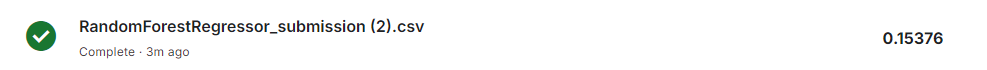

### 5.3 XGBoost Regressor

In [520]:
model=XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(test_data_selected_new)

In [521]:
y_pred=pd.DataFrame(y_pred,columns=['SalePrice'])
submission=pd.merge(id,y_pred,left_index=True, right_index=True)
submission=submission[['Id','SalePrice']]

submission.to_csv('XGBRegressor_submission.csv',index=False)

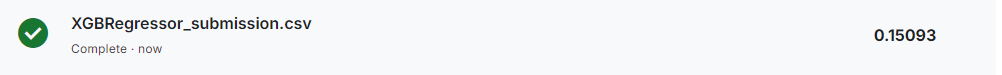

##6. Tunning XGBRegressor


In [522]:
!pip install optuna


In [523]:
import optuna

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Melhores parâmetros:', study.best_params)
print('Melhor RMSE:', study.best_value)


[I 2024-08-16 21:32:33,879] A new study created in memory with name: no-name-288742ff-782e-464a-9295-aa801211bede
[I 2024-08-16 21:32:54,484] Trial 0 finished with value: 32566.934842058923 and parameters: {'max_depth': 8, 'learning_rate': 0.06999804618151428, 'n_estimators': 304, 'subsample': 0.5449378508810989, 'colsample_bytree': 0.779258266452182, 'gamma': 1.6036143586841267}. Best is trial 0 with value: 32566.934842058923.
[I 2024-08-16 21:32:57,012] Trial 1 finished with value: 32299.40544226221 and parameters: {'max_depth': 6, 'learning_rate': 0.21294159602633872, 'n_estimators': 191, 'subsample': 0.9184163745769914, 'colsample_bytree': 0.9058803097141684, 'gamma': 3.5585855528326498}. Best is trial 1 with value: 32299.40544226221.
[I 2024-08-16 21:32:57,200] Trial 2 finished with value: 35199.23488281722 and parameters: {'max_depth': 4, 'learning_rate': 0.20527116572520626, 'n_estimators': 95, 'subsample': 0.7219117929158527, 'colsample_bytree': 0.648706622533493, 'gamma': 4.52

Melhores parâmetros: {'max_depth': 7, 'learning_rate': 0.07045760007757275, 'n_estimators': 262, 'subsample': 0.9376099633749244, 'colsample_bytree': 0.9361204685149033, 'gamma': 0.2156035431393517}
Melhor RMSE: 30141.482892740085


In [524]:
model=XGBRegressor(**study.best_trial.params)
model.fit(X_train,y_train)
y_pred = model.predict(test_data_selected_new)

y_pred=pd.DataFrame(y_pred,columns=['SalePrice'])
submission=pd.merge(id,y_pred,left_index=True, right_index=True)
submission=submission[['Id','SalePrice']]

submission.to_csv('XGBRegressor_OPTUNA_submission.csv',index=False)

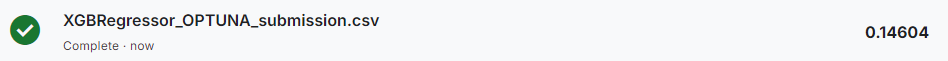